In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext import vocab
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
# Download NLTK tokenizer data
nltk.download('punkt')

# Determine device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import re

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [79]:
DEVICE

device(type='cuda')

In [80]:

filepath = "/kaggle/input/new-train-new/shuffled_train.xlsx"



# Read the Excel file using pandas
data = pd.read_excel(filepath)

# Display the first few rows of the DataFrame
data.head()


,S.NO,author,date,verified,image_url,title_hindi,content_hindi,rating
0,1914,Sushma Bhalotia,Reviewed in India on 19 March 2024,Verified Purchase,NaN,पहले दिन काम नहीं हुआ,"लोहा काम नहीं कर रहा है, गर्म नहीं हो रहा है",2
1,25,Nandakumar,Reviewed in India on 10 April 2024,Verified Purchase,NaN,चार्ज बहुत जल्दी खत्म हो जाता है,मुझे डिज़ाइन पसंद है और कोई शोर नहीं है। लेकिन...,2
2,779,Anand Vishnu Prakash,Reviewed in India on 16 October 2023,Verified Purchase,NaN,उत्पाद ने दो सप्ताह में काम करना बंद कर दिया,मैं किसी को भी इस ब्रश की अनुशंसा नहीं करूंगा।...,2
3,2982,Hara kumar,Reviewed in India on 9 April 2024,Verified Purchase,NaN,उतरते समय चार्ज करना,"उत्पाद अच्छा था, चार्जिंग बहुत खराब थी, हमने फ...",3
4,1839,Ashish A.,Reviewed in India on 10 January 2024,Verified Purchase,NaN,ख़राब गुणवत्ता वाला माउस,इस बार विक्रेता द्वारा आपूर्ति किये गये चूहों ...,2


In [81]:
filepath_test = "/kaggle/input/hindi-dataset/test.xlsx"



# Read the Excel file using pandas
data_test = pd.read_excel(filepath_test)

# Display the first few rows of the DataFrame
data_test.head()

,S.NO,author,date,verified,image_url,title_hindi,content_hindi,rating
0,2046,Topen,Reviewed in India on 20 December 2023,Verified Purchase,https://m.media-amazon.com/images/I/61bhDatJqp...,स्क्रॉल बटन ने 14 दिनों के बाद काम करना बंद कर...,खरीदारी के मात्र 14 दिन बाद स्क्रॉलिंग बटन ने ...,1
1,4015,Narresh,Reviewed in India on 4 March 2024,Verified Purchase,NaN,खराब क्वालिटी,इसका कोई मूल्य नहीं है. अच्छे उत्पाद ही खरीदें...,1
2,280,Rohan Sahu,Reviewed in India on 28 January 2024,Verified Purchase,https://m.media-amazon.com/images/I/61D2R4g99J...,मैं आपको तुरंत चेतावनी देता हूं कि इस उत्पाद क...,मीडिया लोड नहीं किया जा सका. कई ग्राहकों को क्...,1
3,310,Anil,Reviewed in India on 13 April 2024,Verified Purchase,NaN,पैसे की बर्बादी मत खरीदो ð¯,पैसे की बर्बादी मत खरीदो ð¯,1
4,1745,Amazon Customer,Reviewed in India on 12 April 2024,Verified Purchase,NaN,4 महीने से काम भी नहीं,4 महीने बाद भी ब्लूटूथ काम नहीं कर रहा है,1


In [82]:
print(data.shape)

(3527, 8)


In [83]:
print(data_test.shape)

(884, 8)


In [84]:
def plot_rating(ratings):
    # Count occurrences of each rating (1 to 5)
    rating_counts = ratings.value_counts().sort_index()

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plotting the Bar Graph on the first subplot (ax1)
    ax1.bar(rating_counts.index, rating_counts.values, color='skyblue',edgecolor='black', width=0.3)
    ax1.set_title('Count of Ratings (1 to 5)')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    ax1.set_xticks(rating_counts.index)  # Set x-axis ticks to ratings (1 to 5)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Plotting the Pie Chart on the second subplot (ax2)
    ax2.pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'gold', 'lightgreen', 'plum'])
    ax2.set_title('Distribution of Ratings (1 to 5)')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

In [85]:

rating_map = {1: 1, 2: 1, 3: 2, 4: 3, 5: 3}
data['rating'] = data['rating'].map(lambda x: rating_map[x] if x in rating_map else 3)

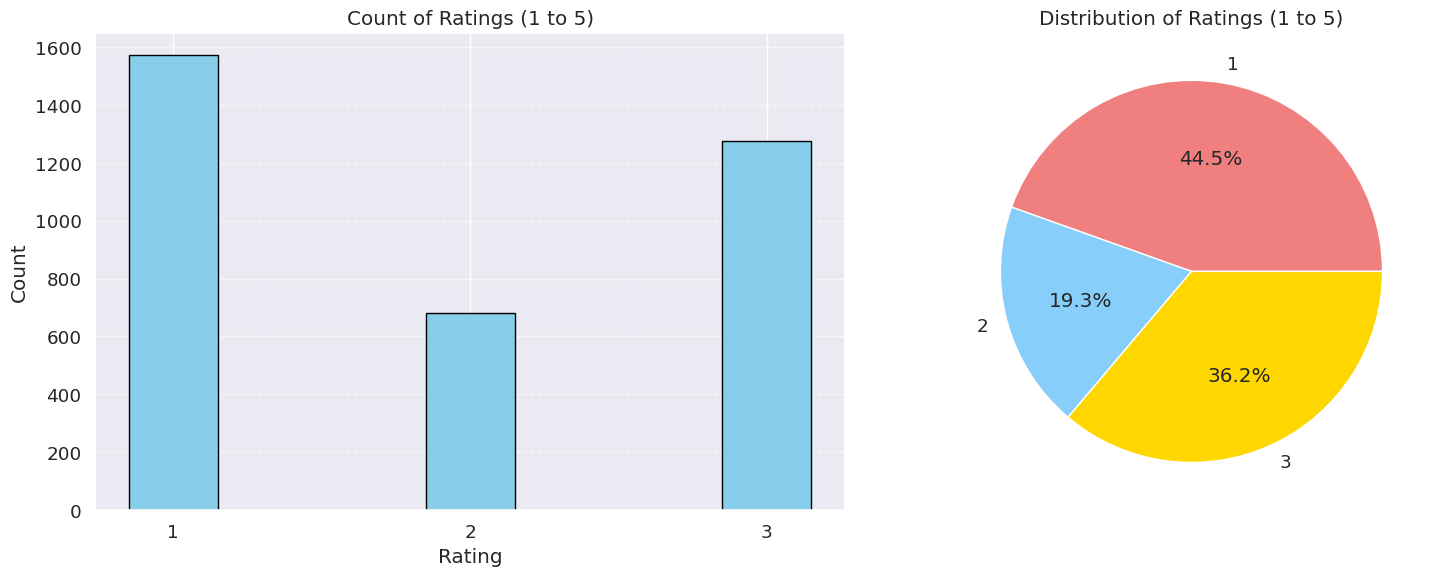

In [86]:
ratings = data['rating']
plot_rating(ratings)

In [87]:
rating_map = {1: 1, 2: 1, 3: 2, 4: 3, 5: 3}
data_test['rating'] = data_test['rating'].map(lambda x: rating_map[x] if x in rating_map else 3)

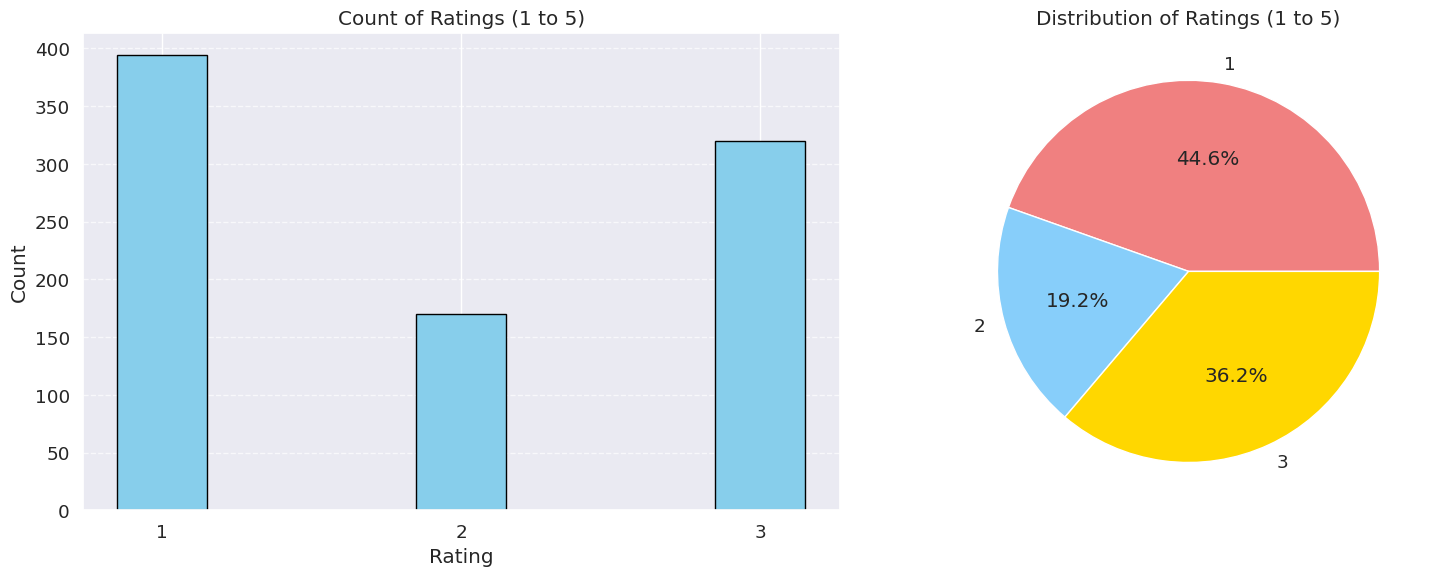

In [88]:
ratings_test = data_test['rating']
plot_rating(ratings_test)

In [89]:
USERNAME_PATTERN = r'@([A-Za-z0-9_]+)'

In [90]:
stopwords_hindi_file = open('/kaggle/input/hindi-stopword/stopwords-hi.txt', 'r') # loading the file with stopwords for hindi dataset
stopwords_hindi = [line.replace('\n','') for line in stopwords_hindi_file.readlines()]

In [91]:
#TODO: implement!
def remove_punctuations(text):
  '''
  this method removes the punctuations in a given text
  using the PUNCTUATION_PATTERN specified.

  Arguments:
  text -- string containing the punctuations.

  Return:
  text -- string with no punctuations.
  '''
  punctuation_marks = ["।", ",", "॥", "?", "!", ":", ";", "-", "(", ")", "ऽ", "ँ", "॑", "॒", "॰"]

  # Remove each punctuation mark from the text
  cleaned_text = text
  for mark in punctuation_marks:
      cleaned_text = cleaned_text.replace(mark, "")


  print(cleaned_text)
  return cleaned_text




def remove_stopwords(text):
  '''
  this method removes the stop words in a given text
  using the stopwords_hindi specified.

  Arguments:
  text -- string containing the stop words.

  Return:
  text -- string with no stop words.
  '''
  return " ".join([word for word in text.split() if word not in stopwords_hindi])



def remove_usernames(text):
  '''
  this method removes any usernames in a given text
  using the USERNAME_PATTERN specified.

  Arguments:
  text -- string containing the usernames.

  Return:
  text -- string with no usernames.
  '''
  return re.sub(USERNAME_PATTERN, '', text)

In [92]:
stopwords_file_path = '/kaggle/input/hindi-stopword/stopwords-hi.txt'


with open(stopwords_file_path, 'r', encoding='utf-8') as file:
    stopwords_list = file.read().split()

# Function to preprocess text
def remove_extra_space(text):
    text = re.sub(r'\s+', ' ', text)

    return text

# Load your dataset

# Merge 'title_hindi' and 'content_hindi' into a single column 'merged_text'


In [93]:
data['merged_text'] = data['title_hindi'] + ' ' + data['content_hindi']

In [94]:
data_test['merged_text'] = data_test['title_hindi'] + ' ' + data_test['content_hindi']

In [95]:
def remove_emojis(text):
    # Define regex pattern for emojis
    emoji_pattern = re.compile("["
        u"U0001F600-U0001F64F"  # emoticons
        u"U0001F300-U0001F5FF"  # symbols & pictographs
        u"U0001F680-U0001F6FF"  # transport & map symbols
        u"U0001F1E0-U0001F1FF"  # flags (iOS)
        u"U00002500-U00002BEF"  # chinese char
        u"U00002702-U000027B0"
        u"U00002702-U000027B0"
        u"U000024C2-U0001F251"
        u"U0001f926-U0001f937"
        u"U00010000-U0010ffff"
        u"u2640-u2642"
        u"u2600-u2B55"
        u"u200d"
        u"u23cf"
        u"u23e9"
        u"u231a"
        u"ufe0f"  # dingbats
        u"u3030"
                           "]+", flags=re.UNICODE)

    # Remove emojis from the text
    cleaned_text = emoji_pattern.sub(r'', text)

    return cleaned_text

In [96]:
# Apply text preprocessing to clean the 'merged_text' column

def processText_url(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'(www\.[^\s]+)|(https?://[^\s]+)', '', text)

    # Remove usernames (mentions)
    text = re.sub(r'@[^\s]+', '', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Replace hashtags with a space (removing them)
    text = re.sub(r'#([^\s]+)', '', text)

    # Remove certain punctuation marks
    text = re.sub(r'[.!:?\-\'"\\/]', '', text)

    # Strip leading and trailing single or double quotes
    text = text.strip('"\'')

    return text


In [97]:
data['cleaned_merged_text'] = data['merged_text'].apply(remove_extra_space)

In [98]:
data_test['cleaned_merged_text'] = data_test['merged_text'].apply(remove_extra_space)

In [99]:
data['cleaned_merged_text'] = data['cleaned_merged_text'].apply(processText_url)

In [100]:
data_test['cleaned_merged_text'] = data_test['cleaned_merged_text'].apply(processText_url)

In [101]:
data['cleaned_merged_text'] = data['cleaned_merged_text'].apply(remove_emojis)

In [102]:
data_test['cleaned_merged_text'] = data_test['cleaned_merged_text'].apply(remove_emojis)

In [103]:
data['cleaned_merged_text'] = data['cleaned_merged_text'].apply(remove_emojis)

In [104]:
data_test['cleaned_merged_text'] = data_test['cleaned_merged_text'].apply(remove_emojis)

In [105]:
data['cleaned_merged_text'] = data['cleaned_merged_text'].apply(remove_stopwords)

In [106]:
data_test['cleaned_merged_text'] = data_test['cleaned_merged_text'].apply(remove_stopwords)

In [107]:
data['cleaned_merged_text'] = data['cleaned_merged_text'].apply(remove_usernames)

In [108]:
data_test['cleaned_merged_text'] = data_test['cleaned_merged_text'].apply(remove_usernames)

In [109]:
print(data['cleaned_merged_text'].head())

0                            दिन काम लोहा काम है, गर्म
1    चार्ज जल्दी खत्म जाता मुझे डिज़ाइन पसंद शोर है...
2    उत्पाद सप्ताह काम बंद मैं ब्रश अनुशंसा करूंगा।...
3    उतरते समय चार्ज उत्पाद अच्छा था, चार्जिंग खराब...
4    ख़राब गुणवत्ता वाला माउस बार विक्रेता आपूर्ति ...
Name: cleaned_merged_text, dtype: object


In [110]:
print(data_test['cleaned_merged_text'].head())

0    स्क्रॉल बटन दिनों काम बंद खरीदारी मात्र दिन स्...
1    खराब क्वालिटी मूल्य अच्छे उत्पाद खरीदें, भले म...
2    मैं आपको तुरंत चेतावनी देता हूं उत्पाद खरीदें।...
3    पैसे बर्बादी मत खरीदो ð¯ पैसे बर्बादी मत खरीदो ð¯
4                          महीने काम महीने ब्लूटूथ काम
Name: cleaned_merged_text, dtype: object


In [111]:
def plot_sentence_length_histogram(sentences):
    # Tokenize each sentence into words and count the number of words in each sentence
    word_counts = sentences.apply(lambda x: len(x.split()))

    # Calculate summary statistics
    max_length = word_counts.max()
    min_length = word_counts.min()
    avg_length = word_counts.mean()

    # Create a histogram of word counts
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.title('Distribution of Sentence Lengths (Number of Words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    # Display summary statistics on the plot
    plt.text(0.8, 0.9, f'Max Length: {max_length}', transform=plt.gca().transAxes)
    plt.text(0.8, 0.85, f'Min Length: {min_length}', transform=plt.gca().transAxes)
    plt.text(0.8, 0.8, f'Avg Length: {avg_length:.2f}', transform=plt.gca().transAxes)

    # Show the plot
    plt.show()

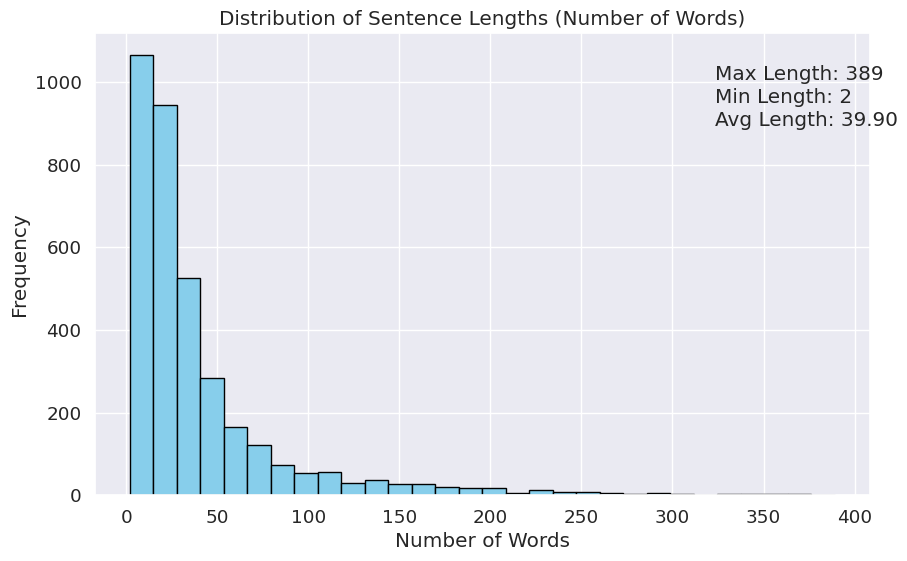

In [112]:
sentences = data['cleaned_merged_text']
plot_sentence_length_histogram(sentences)

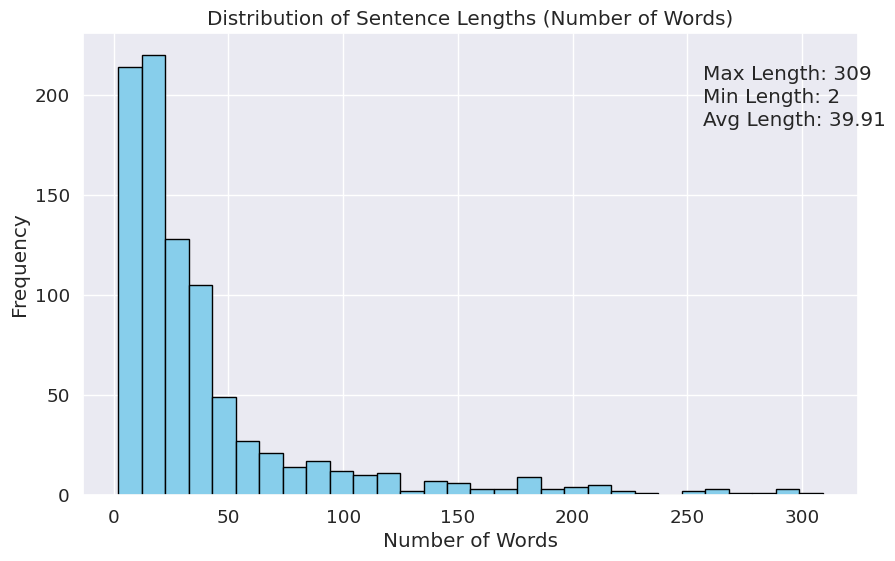

In [113]:
sentences_test = data_test['cleaned_merged_text']
plot_sentence_length_histogram(sentences_test)

In [114]:
class ProcessYelp():
  def __init__(self, cleaned_df, min_freq):
    # self.filepath = filepath
    self.min_freq = min_freq

    df = cleaned_df
    total_words = []
    for i in tqdm(range(len(df)), desc="Vocabulary"):
        line = df['cleaned_merged_text'][i]
        total_words += [[word.lower()] for word in word_tokenize(line)]

    self.vocab = vocab.build_vocab_from_iterator(total_words,
                                                  min_freq = min_freq,
                                                  specials = ['<UNK>', '<PAD>'])
    self.vocab.set_default_index(self.vocab['<UNK>'])




In [115]:
processed_data = ProcessYelp(data, 3)
vocab_tokens = processed_data.vocab.get_itos()

Vocabulary: 100%|██████████| 3527/3527 [00:02<00:00, 1648.43it/s]


In [116]:
len(vocab_tokens)

4071

In [117]:
class LabelData(Dataset):
    def __init__(self, vocab, cleaned_df, max_length=35):
        self.vocab = vocab
        self.data = cleaned_df
        self.max_length = max_length

    def __getitem__(self, index):
        description = self.data.loc[index, 'cleaned_merged_text']
        label = self.data.loc[index, 'rating']

        # Tokenize the description
        tokens = word_tokenize(description.lower())
        
        # Convert tokens to indices using vocab, and pad if necessary
        token_indices = [self.vocab[token.lower()] if token.lower() in self.vocab else self.vocab['<PAD>'] for token in tokens[:self.max_length]]
        token_indices += [self.vocab['<PAD>']] * (self.max_length - len(token_indices))

        return torch.tensor(token_indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.data)

In [118]:
# class LabelData(Dataset):
#     def __init__(self, vocab, cleaned_df, max_length=35):
#         self.vocab = vocab
#         self.data = cleaned_df
#         self.max_length = max_length

#     def __getitem__(self, index):
#         description = self.data.loc[index, 'cleaned_merged_text']
#         label = self.data.loc[index, 'rating']

#         # Tokenize the description
#         tokens = word_tokenize(description.lower())
        
#         # Truncate or pad tokens to max_length
#         if len(tokens) > self.max_length:
#             tokens = tokens[:self.max_length]
#         else:
#             tokens += ['<PAD>'] * (self.max_length - len(tokens))
        
#         token_indices = [self.vocab[token.lower()] if token.lower() in self.vocab else self.vocab['<PAD>'] for token in tokens]

#         return torch.tensor(token_indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

#     def __len__(self):
#         return len(self.data)

In [119]:
label_train_dataset = LabelData(processed_data.vocab,data,55)

In [120]:
label_test_dataset = LabelData(processed_data.vocab,data_test,55)

In [121]:
index = 2  # Choose the index of the data instance you want to access
tokens, label = label_train_dataset[index]
tokens_list = tokens.tolist()  # Convert tensor to list
label_value = label.item()

In [122]:
label

tensor(1)

In [123]:
BATCH_SIZE=1
embedding_dim=300
learning_rate=0.001
hidden_size=150
dropout=0.1
epochs=10

In [124]:
train_dataloader = DataLoader(label_train_dataset, batch_size=1, shuffle=False)

In [125]:
test_dataloader = DataLoader(label_test_dataset, batch_size=1, shuffle=False)

In [126]:
def create_embedding_matrix(processed_data, ft, embedding_dim):
    """
    Create an embedding matrix using pre-trained FastText vectors for words in the vocabulary.

    Args:
    processed_data (object): Object containing processed data with a vocabulary.
    ft (object): Pre-trained FastText model.
    embedding_dim (int): Dimensionality of the embedding vectors.

    Returns:
    embed_matrix (np.ndarray): Embedding matrix where rows correspond to words in the vocabulary,
                                  initialized with FastText vectors if available.
    """

    # Get vocabulary tokens
    vocab_tokens = processed_data.vocab.get_itos()

    # Initialize embedding matrix
    embed_matrix = np.zeros((len(processed_data.vocab), embedding_dim))

    # Iterate over each word in the vocabulary
    for ind, word in enumerate(vocab_tokens):
        embedding_vector = ft.get_word_vector(word)[:embedding_dim]  # Get only the first embedding_dim values
        embed_matrix[ind] = embedding_vector

    return embed_matrix

In [127]:
import fasttext

# Load the FastText model
ft = fasttext.load_model('/kaggle/input/embedding-model/indicnlp.ft.hi.300.bin')

# Specify the word for which you want to find the embedding
# word = "नृत्य"

# Get the word embedding vector for the specified word
# embedding_vector = ft.get_word_vector(word)

# Print the shape and the embedding vector



In [128]:
embedding_dim=300
embed_matrix = create_embedding_matrix(processed_data, ft,embedding_dim)

In [129]:
print(embed_matrix.shape)

(4071, 300)


In [130]:
# np.save('embedding_matrix.npy', embed_matrix)

In [131]:
print(embed_matrix.shape)

(4071, 300)


In [132]:
embed_matrix[3]

array([-0.03302021,  0.27658933, -0.11779855,  0.19755557, -0.13069473,
        0.08244891,  0.01770251, -0.13407095,  0.11100051,  0.04416963,
        0.01368335,  0.14360507,  0.05958683, -0.0923027 ,  0.16523451,
        0.27617359, -0.08327602,  0.19118123, -0.40007389, -0.15402849,
        0.05879085,  0.00171305,  0.25996035,  0.31459028,  0.15229604,
        0.06967574,  0.13857366,  0.06878834,  0.0664608 ,  0.01741378,
       -0.08361454, -0.28951904, -0.31661209, -0.07956032,  0.11197087,
        0.15781502,  0.03315531, -0.16179007,  0.22021486,  0.09416647,
        0.09478069,  0.07130611,  0.23285916, -0.22366703, -0.05133464,
        0.10189582, -0.18489175,  0.20571287, -0.02425337,  0.26554507,
        0.06944957,  0.25566918,  0.05887833,  0.25743037,  0.06748185,
        0.0255497 ,  0.04326249,  0.05521131,  0.28259262, -0.0927472 ,
        0.02587225, -0.21748647,  0.06414101,  0.17423825, -0.09684148,
       -0.18961975, -0.12001439, -0.02476583, -0.09361019,  0.08

In [133]:
embed_matrix[3].shape

(300,)

In [134]:

class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, dropout, embeddings):
        super(ELMo, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings)

        self.layer_1 = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )

        self.layer_2 = nn.LSTM(
            input_size=2 * hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )

        self.dropout = nn.Dropout(dropout)

        self.linear = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, X):
        embeddings = self.embedding(X)

        lstm1_output, _ = self.layer_1(embeddings)

        lstm2_output, _ = self.layer_2(lstm1_output)
        lstm2_output = self.dropout(lstm2_output)

        output = self.linear(lstm2_output)
        output = torch.transpose(output, 1, 2)
        return output





In [135]:
embed_matrix_torch = torch.tensor(embed_matrix, dtype=torch.float64)
embed_matrix_torch = embed_matrix_torch.to(DEVICE)

In [136]:
elmo = (ELMo(len(processed_data.vocab), embedding_dim, hidden_size, dropout, embed_matrix_torch).double().to(DEVICE))
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(elmo.parameters(), lr=learning_rate)

In [137]:
elmo.train()
val_prev = np.inf
for epoch in tqdm(range(epochs)):
    total_train_loss = 0
    total_loss = 0
    for sentence, label in (train_dataloader):
        inp = sentence[:, :-1].to(DEVICE)
        targ = sentence[:, 1:].to(DEVICE)
        optimizer.zero_grad()
        output = elmo(inp)
        loss = criterion(output, targ)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    print("loss:",total_train_loss / len(train_dataloader))

 10%|█         | 1/10 [00:37<05:39, 37.77s/it]

loss: 1.73860013554893


 20%|██        | 2/10 [01:15<05:02, 37.80s/it]

loss: 0.39763300885875574


 30%|███       | 3/10 [01:53<04:24, 37.81s/it]

loss: 0.12680732558880622


 40%|████      | 4/10 [02:31<03:46, 37.81s/it]

loss: 0.047338056383850316


 50%|█████     | 5/10 [03:08<03:08, 37.80s/it]

loss: 0.02239514729108476


 60%|██████    | 6/10 [03:46<02:30, 37.72s/it]

loss: 0.015874660700499733


 70%|███████   | 7/10 [04:24<01:53, 37.70s/it]

loss: 0.012478670217891438


 80%|████████  | 8/10 [05:01<01:15, 37.69s/it]

loss: 0.0100950778654091


 90%|█████████ | 9/10 [05:39<00:37, 37.72s/it]

loss: 0.009357292578759231


100%|██████████| 10/10 [06:17<00:00, 37.75s/it]

loss: 0.007949908613409324


In [138]:
# output_path = 'bilstm_300_IS.pt'
# torch.save(elmo.state_dict(), output_path)

In [156]:
class LearnableFunction(nn.Module):
    def __init__(self, input_size, output_size):
        super(LearnableFunction, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(output_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class DownstreamLearnable(nn.Module):
    def __init__(self, embedding_size, dropout_prob=0.5):
        super(DownstreamLearnable, self).__init__()

        # Define the learnable function to combine word representations
        self.learnable_function = LearnableFunction(3 * embedding_size, embedding_size)

        # Other components of your model
        self.embedding_size = embedding_size
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(embedding_size, 3)  # Output layer with 4 units for classification

    def forward(self, sentence):
        # Implement your forward pass using the learnable function and other components
        embeddings = elmo.embedding(sentence)
        out_1, _ = elmo.layer_1(embeddings)
        out_2, _ = elmo.layer_2(out_1)

        # Combine word representations using the learnable function
        combined_representation = torch.cat([embeddings, out_1, out_2], dim=2).to(torch.float32)
        learned_embedding = self.learnable_function(combined_representation)
        learned_embedding=torch.mean(learned_embedding, dim=1)
        output = self.dropout(learned_embedding)

        # Apply linear transformation
        output = self.linear(output)
        return output

In [140]:
import torch.nn.functional as F

class Downstream(nn.Module):
    def __init__(self, embedding_size, dropout_prob=0.5):
        super(Downstream, self).__init__()

        self.s1 = nn.Parameter(torch.ones(1))
        self.s2 = nn.Parameter(torch.ones(1))
        self.s3 = nn.Parameter(torch.ones(1))
        self.alpha = nn.Parameter(torch.ones(1))

        # Change the output layer to 4 classes
        self.linear = nn.Linear(embedding_size, 3)  # Output layer with 4 units for 4 classes

        # Add dropout layer
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, sentence):
        embeddings = elmo.embedding(sentence)
        out_1, _ = elmo.layer_1(embeddings)
        out_2, _ = elmo.layer_2(out_1)
        
        s_sum = self.s1 + self.s2 + self.s3

        output = self.alpha * (
            self.s1 / s_sum * embeddings
            + self.s2 / s_sum * out_1
            + self.s3 / s_sum * out_2
        ).to(torch.float32)
        aggregated_output = torch.mean(output, dim=1)

        # Apply dropout before feeding into the linear layer
        output = self.dropout(aggregated_output)

        output = self.linear(output)  # Apply linear transformation
        return output


In [157]:
downstream_model= DownstreamLearnable(embedding_dim).to(DEVICE)
optimizer = optim.Adam(downstream_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [159]:
def train_model(model, train_dataloader, criterion, optimizer, epochs, device):
    train_losses = []

    # Training loop
    for epoch in tqdm(range(15)):
        total_loss_train = 0

        model.train()  # Set the model to training mode
        for i, (sentence, label) in enumerate(train_dataloader):
            sentence, label = sentence.to(device), label.to(device)
            label -= 1  # Adjust labels (assuming they are 1-based)

            optimizer.zero_grad()
            outputs = model(sentence)

            # Calculate loss
            batch_loss = criterion(outputs, label)
            total_loss_train += batch_loss.item()

            # Backpropagation
            batch_loss.backward()
            optimizer.step()

        # Calculate average training loss for the epoch
        avg_train_loss = total_loss_train / len(train_dataloader)
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")

    # Plot the training loss graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

  7%|▋         | 1/15 [00:28<06:44, 28.88s/it]

Epoch 1, Train Loss: 0.8814929053011568


 13%|█▎        | 2/15 [00:57<06:14, 28.79s/it]

Epoch 2, Train Loss: 0.7445681822154843


 20%|██        | 3/15 [01:26<05:46, 28.84s/it]

Epoch 3, Train Loss: 0.6757054240066008


 27%|██▋       | 4/15 [01:55<05:18, 28.94s/it]

Epoch 4, Train Loss: 0.5728264031076603


 33%|███▎      | 5/15 [02:24<04:49, 28.92s/it]

Epoch 5, Train Loss: 0.46426585788267233


 40%|████      | 6/15 [02:53<04:19, 28.86s/it]

Epoch 6, Train Loss: 0.3528234274746437


 47%|████▋     | 7/15 [03:22<03:51, 28.92s/it]

Epoch 7, Train Loss: 0.28619473297584724


 53%|█████▎    | 8/15 [03:51<03:22, 28.89s/it]

Epoch 8, Train Loss: 0.24746572150870383


 60%|██████    | 9/15 [04:19<02:53, 28.87s/it]

Epoch 9, Train Loss: 0.20684249526923013


 67%|██████▋   | 10/15 [04:48<02:24, 28.86s/it]

Epoch 10, Train Loss: 0.16885003279469948


 73%|███████▎  | 11/15 [05:17<01:55, 28.83s/it]

Epoch 11, Train Loss: 0.1486299512524501


 80%|████████  | 12/15 [05:46<01:26, 28.91s/it]

Epoch 12, Train Loss: 0.12830841170320348


 87%|████████▋ | 13/15 [06:15<00:57, 28.90s/it]

Epoch 13, Train Loss: 0.14236722181191577


 93%|█████████▎| 14/15 [06:44<00:28, 28.86s/it]

Epoch 14, Train Loss: 0.12040513668601964


100%|██████████| 15/15 [07:13<00:00, 28.88s/it]

Epoch 15, Train Loss: 0.11601170422707713


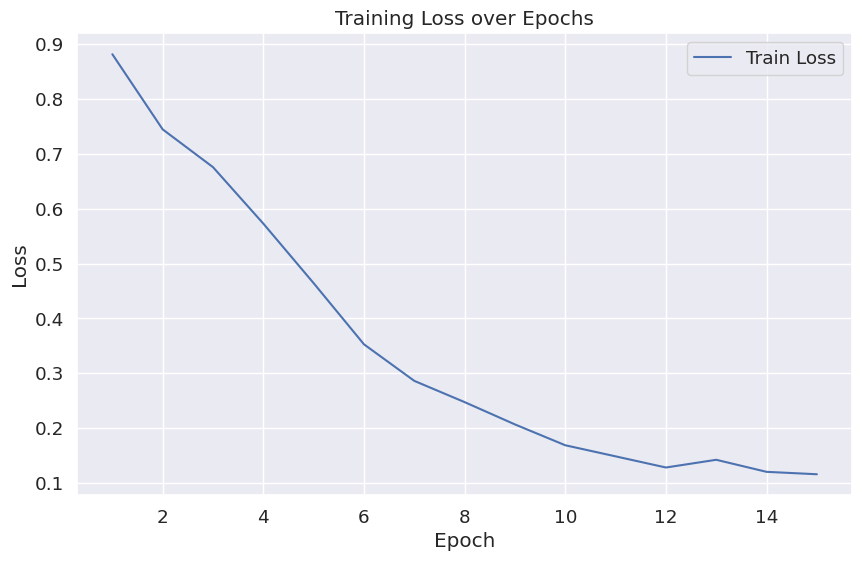

In [160]:
train_model(downstream_model, train_dataloader, criterion, optimizer, epochs, DEVICE)


In [161]:
y_true = []
y_pred = []

downstream_model.eval()

with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader):
        model_input = inputs.to(DEVICE)
        outputs = downstream_model(model_input)

        targets = targets.tolist()

        y_true += targets
        y_pred += (torch.argmax(outputs, dim=1).tolist())

# Adjust y_pred to align with the range of y_true (subtract 1 from each element)


y_pred_adjusted = [x + 1 for x in y_pred]

100%|██████████| 884/884 [00:03<00:00, 265.24it/s]


In [162]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_true, y_pred_adjusted))

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.77      0.76       394
           2       0.41      0.24      0.30       170
           3       0.70      0.83      0.76       320

    accuracy                           0.69       884
   macro avg       0.62      0.61      0.61       884
weighted avg       0.67      0.69      0.67       884



In [146]:
y_train = []
y_train_pred = []

downstream_model.eval()

with torch.no_grad():
    for inputs, targets in tqdm(train_dataloader):
        model_input = inputs.to(DEVICE)
        outputs = downstream_model(model_input)

        targets = targets.tolist()

        y_train += targets
        y_train_pred += (torch.argmax(outputs, dim=1).tolist())

# Adjust y_pred to align with the range of y_true (subtract 1 from each element)
y_pred_adjusted_train = [pred + 1 for pred in y_train_pred]


100%|██████████| 3527/3527 [00:13<00:00, 269.78it/s]


In [147]:
print("Classification Report:")
print(classification_report(y_train, y_pred_adjusted_train))

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.94      0.86      1571
           2       0.65      0.53      0.58       680
           3       0.90      0.78      0.83      1276

    accuracy                           0.80      3527
   macro avg       0.78      0.75      0.76      3527
weighted avg       0.80      0.80      0.80      3527



In [148]:
def plot_confusion_matrix_and_classification_report(true_labels, predicted_labels, class_names, test_train):
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)  # Adjust font scale
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix'+test_train)
    plt.show()

    # Plot the classification report
    plt.figure(figsize=(12, 10))
    report = classification_report(
        true_labels, predicted_labels, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    sns.heatmap(df.iloc[:-1, :].T, annot=True, cmap="YlGnBu", cbar=False)
    plt.title('Classification Report'+test_train)
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

In [149]:
import seaborn as sns

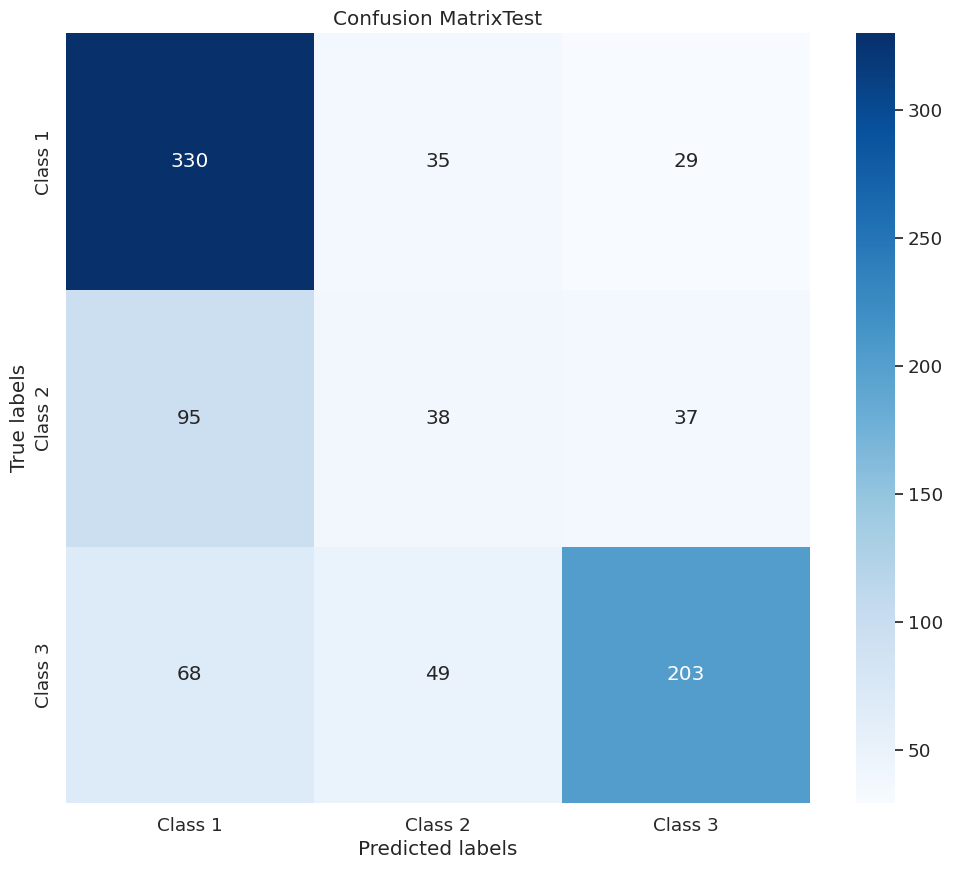

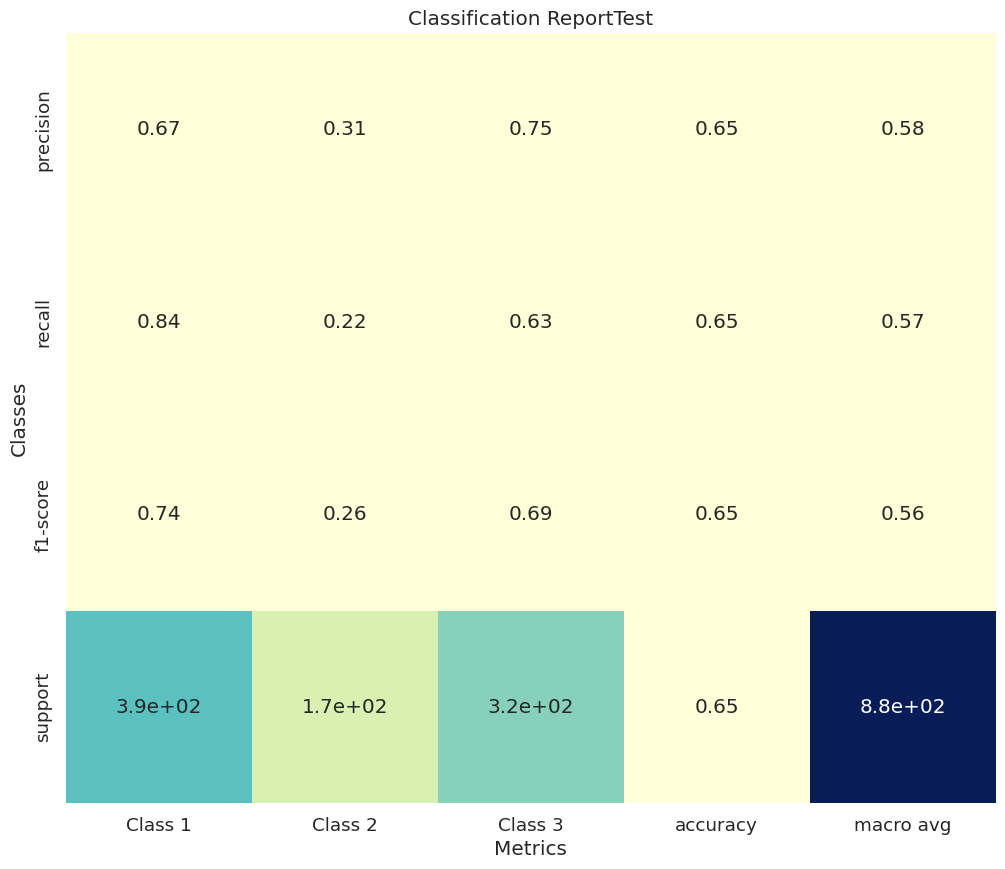

In [150]:
class_names =['Negative', 'Neutral', 'Positive']


# plot_confusion_matrix_and_classification_report(true_labels_train, predicted_labels_train, class_names,"Train")
plot_confusion_matrix_and_classification_report(y_true, y_pred_adjusted, class_names, "Test")